# Modeling Dengue
This is an assignment for INFO 370 Core Method in Data Science (Autumn 2018) at University of Washington. The task for this project is to measure the **strength of association** between different environmental variables and the number of cases of Dengue. This Jupyter Notebook is a **polished report** of our analysis on Dengue (source of dataset: [link](https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread)).


## Problem Overview
   Dengue fever is the leading cause of illness and death in the tropics and subtropics, regions which contain a little more than one-third of the world population. Mild cases of Dengue fever can cause high fever, rash and muscle, and joint pain, while more severe cases can lead to severe bleeding, a sudden drop in blood pressure and death. Dengue is transmitted to people by mosquitoes, and because of this relationship, the disease’s spread spikes yearly when rainfall is optimal for mosquitoe breeding. In fact, this relationship between the disease and the mosquito breeding period is so entwined that, every breeding season Dengue is classified as an epidemic within the tropics and sub-tropics. This relationship between the disease and mosquitoes also means that environmental factors that promote mosquito life will also work as indicators for the spread of Dengue. Limiting exposure to mosquitos in at-risk areas is the only known prevention method for the disease, as a vaccine has yet to be developed. This coupled with the fact that the disease is rapidly spreading, increasing from having cases in 9 countries in 1970 to over 100 countries by 2015, makes it a high priority for many world health organizations. In order to perform our predictions, we were given access to data from a variety of U.S. Federal Government agencies. 
   
   Citations:
   1. Centers for Disease Control and Prevention. (n.d.). Retrieved from [link](https://www.cdc.gov/).
   2. Here's the ideal temp for mosquito-borne diseases. (2017, May 05). Retrieved from [link](https://www.futurity.org/climate-change-mosquito-diseases-1420452/).
   3. 
   

### Pertinent Variables 
Because dengue is carried by mosquitoes, it’s transmission dynamics are related to climate variables such as temperature and precipitation. To predict the number of dengue fever cases (the `total_cases` label for each `(city, year, weekofyear)` ) based on the provided datasets, it’s important to look at these following information ([source](https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/page/82/#features_list)):

#### City and Date Indicators
- There are data for _two cities_, San Juan (`sj`) and Iquitos (`iq`) in the `city` column. 
- The date indicator is provided on a `(year, weekofyear, week_start_date)` timescale, which is given in yyyy-mm-dd format.

#### NOAA's GHCN daily climate data weather station measurements
- `station_avg_temp_c` – _Average_ temperature
- `station_precip_mm` – _Total_ precipitation

#### PERSIANN satellite precipitation measurements (0.25x0.25 degree scale)
- `precipitation_amt_mm` – _Total_ precipitation

#### NOAA's NCEP Climate Forecast System Reanalysis measurements (0.5x0.5 degree scale)
- `reanalysis_sat_precip_amt_mm` – _Total_ precipitation
- `reanalysis_precip_amt_kg_per_m2` – _Total_ precipitation **(? same as ↾)**
- `reanalysis_dew_point_temp_k` – _Mean_ dew point temperature
- `reanalysis_air_temp_k` – _Mean_ air temperature
- `reanalysis_avg_temp_k` – _Average_ air temperature **(? same as ↾)**
- `reanalysis_relative_humidity_percent` – _Mean_ relative humidity
- `reanalysis_specific_humidity_g_per_kg` – _Mean_ specific humidity


As you can see, there are a few columns that represent the same data point (e.g. `precipitation`) from different sources. Are there any _substantive_ differences from the sources and why would they all be included?

## Set Up

In [144]:
import numpy as np
import pandas as pd
import seaborn as sns # for visualiation
from scipy.stats import ttest_ind # t-tests
from scipy.stats import pearsonr
import statsmodels.formula.api as smf # linear modeling
import statsmodels.api as sm
import matplotlib.pyplot as plt # plotting
import matplotlib
from sklearn import metrics
from sklearn.preprocessing import StandardScaler


In [145]:
dengue_features = pd.read_csv("data/dengue_features_train.csv")
dengue_labels = pd.read_csv("data/dengue_labels_train.csv")

## Data Preperation

In [146]:
# Remove all rows with na values
dengue_features = dengue_features.dropna()
# Add column that is average of all three temperature measurements
dengue_features["avg_air_temp_k"] = (dengue_features["reanalysis_air_temp_k"] + dengue_features["reanalysis_avg_temp_k"] + (dengue_features["station_avg_temp_c"] + 273.15)) / 3

#Create a merged data table for exploration
merged_data = pd.merge(dengue_features, dengue_labels, on=['city', 'weekofyear', 'year'], how='outer')
merged_data = merged_data.dropna()

data_by_city = merged_data.groupby("city")
sj_data = data_by_city.get_group("sj")
iq_data = data_by_city.get_group("iq")

## Exploratory Data Analysis

Below are 5 exploratory visualizations that expose pertinent information about the dataset.

<Figure size 432x288 with 0 Axes>

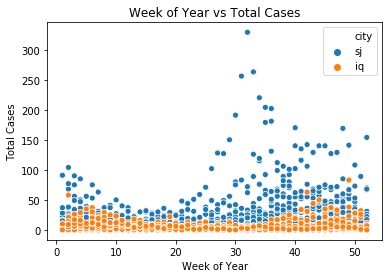

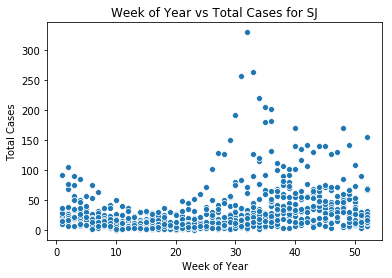

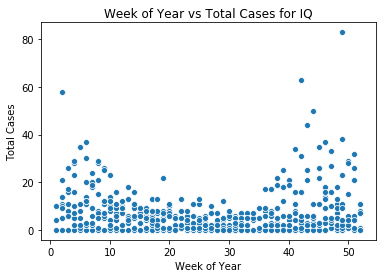

<Figure size 432x288 with 0 Axes>

In [81]:
# Scatterplot showing the distribution over times
plot = sns.scatterplot(x="weekofyear", y="total_cases", hue="city", data=merged_data)
plot.set(xlabel='Week of Year', ylabel='Total Cases', title="Week of Year vs Total Cases")
plt.figure()

plot = sns.scatterplot(x="weekofyear", y="total_cases", data=sj_data)
plot.set(xlabel='Week of Year', ylabel='Total Cases', title="Week of Year vs Total Cases for SJ")
plt.figure()

plot = sns.scatterplot(x="weekofyear", y="total_cases", data=iq_data)
plot.set(xlabel='Week of Year', ylabel='Total Cases', title="Week of Year vs Total Cases for IQ")
plt.figure()

## Week of year vs. Total Cases
- These plots show the total cases by each week of the year for each city. In the cases of both city, the number of cases starts out moderatly high at week zero, with a slow decline and steadying out until around week 35-30. At this point the number of total cases begins to increase rapidly.

1. What is the distribution of the number of cases of Dengue each week?

> The above scatterplot shows a **moderate**, **positive**, **non-linear** association between _week of year_ and the number of _total cases_ for both _cities_.

2. How does the number of cases fluctuate over time? Do these temporal relationships persist in both locations?

> Both cities see a spike in total cases, that begins around the week 30 mark continues to increase until around week 50 and then declines from there, staying around the same number for weeks 10-20.


<Figure size 432x288 with 0 Axes>

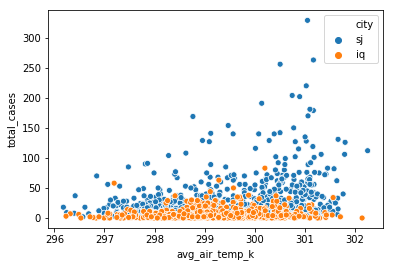

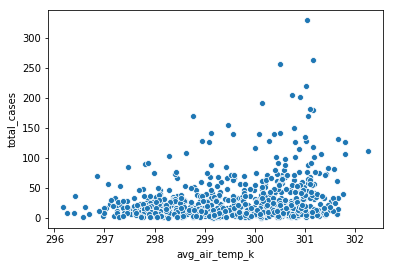

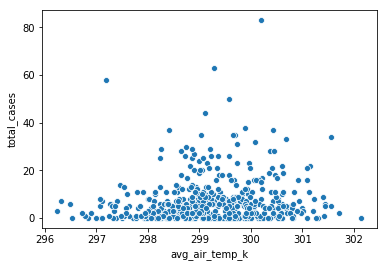

<Figure size 432x288 with 0 Axes>

In [82]:
sns.scatterplot(x="avg_air_temp_k", y="total_cases", hue="city", data=merged_data)
plt.figure()
sns.scatterplot(x="avg_air_temp_k", y="total_cases", data=sj_data)
plt.figure()
sns.scatterplot(x="avg_air_temp_k", y="total_cases", data=iq_data)
plt.figure()

## Average Air Temp vs Total Cases
- Here we examine the relationship between average temperature and total cases in each city. In both cases the number of total cases seems to spike in the 299-301 Kelvin range. This suggests that this is the optimal temperature for mosqiuto reproduction, and therefore casues a spike in dengue fever.

<Figure size 432x288 with 0 Axes>

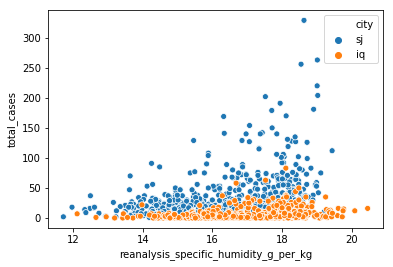

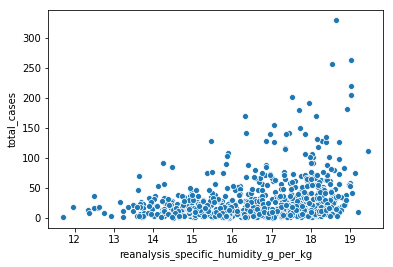

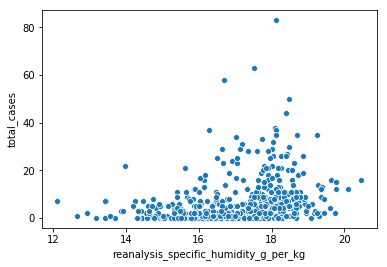

<Figure size 432x288 with 0 Axes>

In [78]:
sns.scatterplot(x="reanalysis_specific_humidity_g_per_kg", y="total_cases", hue="city", data=merged_data)
plt.figure()
sns.scatterplot(x="reanalysis_specific_humidity_g_per_kg", y="total_cases", data=sj_data)
plt.figure()
sns.scatterplot(x="reanalysis_specific_humidity_g_per_kg", y="total_cases", data=iq_data)
plt.figure()

## Humidity vs Total Cases
- Here we examine the relationship between grams of humidity per kg in both cities. As with air temp the number to cases of dengue fever begins to spike around the same humidity level of 16 for both cities.

<Figure size 432x288 with 0 Axes>

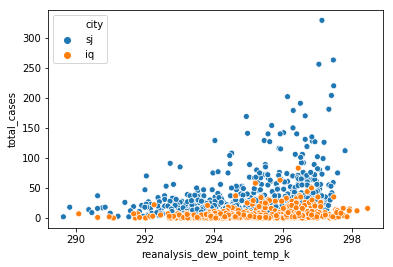

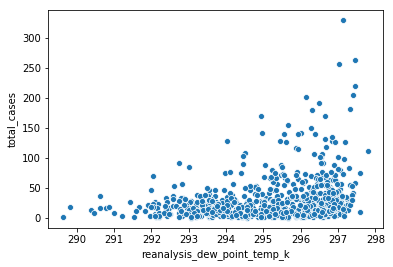

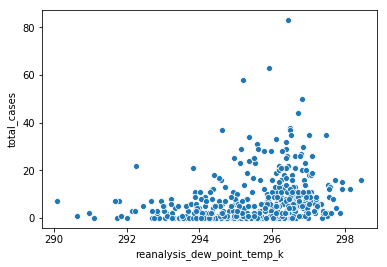

<Figure size 432x288 with 0 Axes>

In [128]:
sns.scatterplot(x="reanalysis_dew_point_temp_k", y="total_cases", hue="city", data=merged_data)
plt.figure()
sns.scatterplot(x="reanalysis_dew_point_temp_k", y="total_cases", data=sj_data)
plt.figure()
sns.scatterplot(x="reanalysis_dew_point_temp_k", y="total_cases", data=iq_data)
plt.figure()

## Reanalysis Dew Point

# Generate Model 

In [130]:
## Forward selection method, acquired from slides (put reference later)
def forward_selected(data, response):
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

In [152]:
def preprocess_data(dengue_features, dengue_labels):
    # load data and set index to city, year, weekofyear
    df = dengue_features
    
    # select features we want
    features = ['reanalysis_specific_humidity_g_per_kg', 
                 'reanalysis_dew_point_temp_k', 
                 'avg_air_temp_k', 
                 'station_min_temp_c']
    df = df[features]
    
    # fill missing values
    df.fillna(method='ffill', inplace=True)

    labels = dengue_labels
    df = df.join(labels)
    
    data_by_city = df.groupby("city")
    sj = data_by_city.get_group("sj")
    iq = data_by_city.get_group("iq")
    
    return sj, iq

In [154]:
sj_train, iq_train = preprocess_data(dengue_features, dengue_labels)
sj_train_subtrain = sj_train.head(800)
sj_train_subtest = sj_train.tail(sj_train.shape[0] - 800)

iq_train_subtrain = iq_train.head(400)
iq_train_subtest = iq_train.tail(iq_train.shape[0] - 400)

In [157]:
def get_best_model(train, test):
    # Step 1: specify the form of the model
    model = forward_selected(merged_data, 'total_cases')
    
    model_formula = model.model.formula
    
    grid = 10 ** np.arange(-8, -3, dtype=np.float64)
                    
    best_alpha = []
    best_score = 1000
        
    # Step 2: Find the best hyper parameter, alpha
    for alpha in grid:
        model = smf.glm(formula=model_formula,
                        data=train,
                        family=sm.families.NegativeBinomial(alpha=alpha))

        results = model.fit()
        predictions = results.predict(test).astype(int)
        score = eval_measures.meanabs(predictions, test.total_cases)

        if score < best_score:
            best_alpha = alpha
            best_score = score
            
    # Step 3: refit on entire dataset
    full_dataset = pd.concat([train, test])
    model = smf.glm(formula=model_formula,
                    data=full_dataset,
                    family=sm.families.NegativeBinomial(alpha=best_alpha))

    fitted_model = model.fit()
    return fitted_model

In [ ]:
sj_best_model = get_best_model(sj_train_subtrain, sj_train_subtest)
iq_best_model = get_best_model(iq_train_subtrain, iq_train_subtest)